In [2]:
import gensim #pip install gensim
import pprint
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models
import time

''' 
 default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS
'''

" \n default_term_info = default_term_info.sort_values(\n        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS\n"

In [3]:
#1. Creazione del TF-IDF (Term Frequency - Inverse Document Frequency), assegnamo un peso ad ogni parola
#  - TF: frequenza del termine nel documento: num. occorrenze / num. totale di parole nel documento
#  - IDF: inverso della frequenza del termine nei documenti: log(num. totale di documenti / num. documenti che contengono il termine)
#  - TF-IDF: prodotto delle due precedenti (risulta elevato quando la parola è molto presente nel documento e poco presente negli altri documenti)

source = './doc/cleaned.csv'
df = pd.read_csv(source)

#Tokenizzazione
tweets = df['lemmatized_text'].apply(lambda text: word_tokenize(text))

# Create a dictionary
dictionary = corpora.Dictionary(tweets)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in tweets]

# Train the TF-IDF model
tfidf = models.TfidfModel(corpus)

# Transform the corpus into TF-IDF vectors
tfidf_corpus = tfidf[corpus]

In [4]:
# Show some results
for i, doc in enumerate(tfidf_corpus):
    if i > 1:
        break
    print(f"TF-IDF values for document {i}:")
    for token_id, tfidf_value in doc:
        word = dictionary[token_id]  # Get the word corresponding to the token_id
        print(f"Token ID: {token_id}, Word: {word}, TF-IDF Value: {tfidf_value}")
    print("\n")

TF-IDF values for document 0:
Token ID: 0, Word: allegedly, TF-IDF Value: 0.12172950724309914
Token ID: 1, Word: atomic, TF-IDF Value: 0.163481829089258
Token ID: 2, Word: ban, TF-IDF Value: 0.08655530596048583
Token ID: 3, Word: beijing, TF-IDF Value: 0.13310403046993044
Token ID: 4, Word: bloomberg, TF-IDF Value: 0.15428935467079022
Token ID: 5, Word: briefcase, TF-IDF Value: 0.20824049599085984
Token ID: 6, Word: carrying, TF-IDF Value: 0.13378286214782126
Token ID: 7, Word: chemical, TF-IDF Value: 0.1306115583460694
Token ID: 8, Word: come, TF-IDF Value: 0.07254718265516213
Token ID: 9, Word: conducted, TF-IDF Value: 0.1424181067119247
Token ID: 10, Word: decade, TF-IDF Value: 0.09115214120084408
Token ID: 11, Word: established, TF-IDF Value: 0.13847385049522498
Token ID: 12, Word: explosion, TF-IDF Value: 0.1441423299143476
Token ID: 13, Word: filmed, TF-IDF Value: 0.16942602716846464
Token ID: 14, Word: hour, TF-IDF Value: 0.09567284726388772
Token ID: 15, Word: model, TF-IDF Val

In [7]:
def execute_LDA(n_topic, corpus, dictionary, epochs):
    start_time = time.time()
    
    logging.basicConfig(level=logging.WARNING)
    
    #execute
    lda_model = LdaMulticore(
        corpus = corpus, #corpus in tfidf
        id2word = dictionary, #dizionario (vocabolario dei miei documenti)
        num_topics = n_topic,
        random_state = 42, #per riproducibilità
        passes = epochs,
        per_word_topics = True,
        workers = 3
        )
    
    '''#LDA TRAINING
    lda_model = LdaModel(
    corpus = corpus, #corpus in tfidf
    id2word = dictionary, #dizionario (vocabolario dei miei documenti)
    alpha = 'auto',
    eta = 'auto',
    num_topics = n_topic,
    random_state = 42, #per riproducibilità
    passes = epochs,
    per_word_topics = True) #aggiunge maggiori info'''
    
    #save model
    lda_model.save(f'models/lda_model_{n_topic}_{epochs}')
    
    
    # Compute Coherence Score u_mass
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
    coherence_umass = coherence_model_lda.get_coherence()
    
    # Compute Coherence Score c_v
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
    coherence_cv = coherence_model_lda_cv.get_coherence()
    
    end_time = time.time()
    
    return lda_model, coherence_umass, coherence_cv, end_time - start_time

def print_topic(num, lda_model):
    topics = lda_model.show_topics(num_topics=num, num_words=10)  # You can adjust the number of words as needed
    print("\n----- TOPIC -----")
    i = 0
    for topic in topics:
        i = i + 1
        topic_words = topic[1].split("+")
        words = [word.split("*")[1].strip() for word in topic_words]
        topic_str = ', '.join(words)
        print(f"Topic{i}: {topic_str}")
    #lda_model.show_topics(formatted=False)
    

In [8]:
#Execute LDA
n_topics = []
coherence_umass = []
coherence_cv = []
epochs = 100

trial = [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for i in trial:
    print(f"\n\nExecuting LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, umass, cv, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(i, model)
    



Executing LDA with 8 topics and 100 epochs


Execution time: 13.006 min
Coherence umass: -9.200 e Coherence cv: 0.536

----- TOPIC -----
Topic1: "border", "menendez", "illegal", "migrant", "dakota", "wall", "southern", "bob", "immigrant", "mccarthy"
Topic2: "day", "today", "great", "join", "thank", "happy", "tune", "tonight", "live", "honor"
Topic3: "taylor", "music", "copy", "hypocrisy", "suck", "livestream", "author", "score", "rubio", "embarrassing"
Topic4: "newsom", "editor", "gavin", "faa", "letter", "productive", "politico", "analysis", "overturned", "fulton"
Topic5: "biden", "trump", "people", "amp", "joe", "president", "ukraine", "house", "government", "american"
Topic6: "gun", "violence", "shooting", "weapon", "assault", "pact", "michigander", "fentanyl", "writes", "toxic"
Topic7: "trump", "vote", "election", "republican", "gop", "debate", "candidate", "poll", "democrat", "voter"
Topic8: "american", "job", "act", "care", "year", "family", "amp", "working", "health", "work"


Executing LDA with 11 topics and 100 epochs
Ex

N.Topics: [8, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Coherence score: [-9.200441042234985, -7.178833185929441, -7.934364339070924, -9.295775880818848, -7.895624630072998, -9.895410012650816, -10.061093923152749, -8.384642388693546, -9.081364282865856, -8.790754822324054, -10.354005081963097]


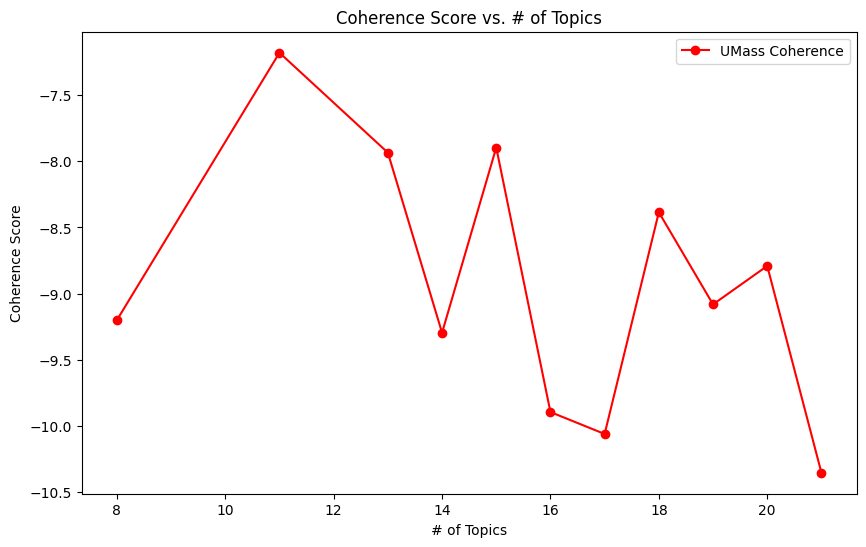

In [14]:

# Load the saved LDA model
#lda_model_up = LdaModel.load("lda_model")

print("N.Topics:", n_topics)
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(n_topics, coherence_umass, marker='o', color='red', label='UMass Coherence')
#plt.plot(n_topics, coherence_cv, marker='*', color = 'blue', label = 'CV Coherence')
plt.legend(loc='best')
plt.title('Coherence Score vs. # of Topics')
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [22]:
#pyLDAvis (https://siqi-zhu.medium.com/ldavis-a-deep-dive-into-the-popular-topic-modeling-tool-d0c61a03e969)
pyLDAvis.enable_notebook()
model = LdaModel.load("models/lda_model_15_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)
#pyLDAvis.save_html(vis, 'lda_visualization_15_100.html') #da fare dopo la visualizzazione altrimenti non lo mostra

In [23]:
model = LdaModel.load("models/lda_model_11_100")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [24]:
#Addestramento ulteriore per 11 topic
coherence_umass = []
coherence_cv = []
epochs = [150, 200, 250, 300, 350, 400, 500, 600]

for e in epochs:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)
    




Executing LDA with 11 topics and 150 epochs
Execution time: 16.419 min
Coherence umass: -8.444 e Coherence cv: 0.584

----- TOPIC -----
Topic1: "tuberville", "spring", "rsvp", "pact", "exposed", "schumer", "eligible", "yorkers", "till", "contact"
Topic2: "day", "today", "thank", "woman", "great", "happy", "year", "work", "community", "country"
Topic3: "larry", "elder", "adviser", "upgrade", "joy", "anybody", "suck", "profile", "trading", "surrender"
Topic4: "menendez", "newsom", "bob", "pet", "resign", "mcconnell", "mitch", "gavin", "dobbs", "shame"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "democrat", "know", "think"
Topic6: "texas", "poll", "gun", "laura", "ingraham", "angle", "virginian", "lean", "weapon", "rating"
Topic7: "tune", "tonight", "live", "join", "watch", "listen", "hall", "town", "debate", "joining"
Topic8: "american", "job", "act", "amp", "care", "working", "family", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election", "repub

In [31]:
#Addestramento ulteriore per 11 topic

for e in [350, 400, 500, 600]:
    print(f"\n\nExecuting LDA with 11 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(11, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(11, model)
    




Executing LDA with 11 topics and 350 epochs
Execution time: 43.854 min
Coherence umass: -8.373 e Coherence cv: 0.573

----- TOPIC -----
Topic1: "tuberville", "rsvp", "spring", "exposed", "schumer", "till", "highway", "rebuilding", "yorkers", "contact"
Topic2: "day", "today", "thank", "great", "happy", "woman", "year", "work", "community", "family"
Topic3: "larry", "elder", "lowest", "transit", "trading", "upgrade", "suck", "joy", "anybody", "percent"
Topic4: "menendez", "resign", "newsom", "bob", "ramaswamy", "vivek", "gavin", "mcconnell", "mitch", "pet"
Topic5: "trump", "people", "biden", "like", "want", "amp", "party", "know", "democrat", "think"
Topic6: "texas", "gun", "poll", "virginian", "lean", "rating", "writes", "prevention", "toss", "weapon"
Topic7: "tune", "tonight", "live", "join", "listen", "hall", "watch", "town", "joining", "tomorrow"
Topic8: "american", "job", "act", "amp", "working", "family", "care", "cost", "year", "economy"
Topic9: "trump", "vote", "gop", "election

[-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747] [150, 200, 250, 300, 350, 400, 500, 600]
11 topic
Coherence score: [-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747]


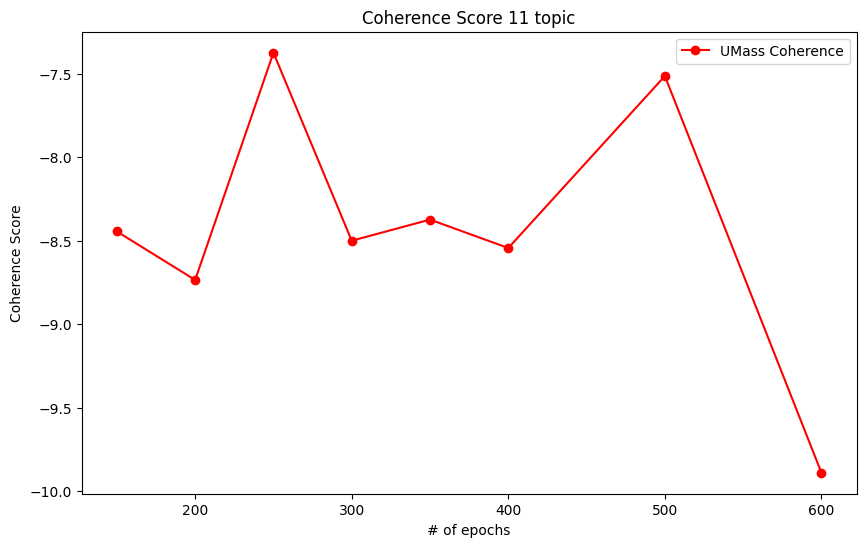

In [36]:
#Mostro i risultati per l'ulteriore addestramento
epochs = [150,200, 250, 300, 350, 400, 500, 600]
print(coherence_umass, epochs)
print("11 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_umass, marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 11 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()

In [ ]:
#display
model = LdaModel.load("models/lda_model_11_150")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [ ]:
model = LdaModel.load("models/lda_model_11_200")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [ ]:
model = LdaModel.load("models/lda_model_11_250")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [ ]:
model = LdaModel.load("models/lda_model_11_300")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [37]:
model = LdaModel.load("models/lda_model_11_500")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)

In [38]:
#Addestramento ulteriore per 15 topic
epochs = [150,200, 250, 300, 350, 400, 500, 600]
for e in epochs:
    print(f"\n\nExecuting LDA with 15 topics and {e} epochs")
    model, umass, cv, time_s = execute_LDA(15, tfidf_corpus, dictionary, e)
    coherence_umass.append(umass)
    coherence_cv.append(cv)
    print(f"Execution time: {(time_s/60):.3f} min")
    print(f"Coherence umass: {umass:.3f} e Coherence cv: {cv:.3f}")
    print_topic(15, model)
    






Executing LDA with 15 topics and 150 epochs
Execution time: 17.419 min
Coherence umass: -9.534 e Coherence cv: 0.597

----- TOPIC -----
Topic1: "trump", "debate", "gop", "candidate", "election", "republican", "presidential", "desantis", "primary", "vote"
Topic2: "today", "great", "day", "thank", "join", "happy", "community", "amp", "year", "state"
Topic3: "honor", "woman", "freedom", "sacrifice", "day", "american", "nation", "country", "history", "god"
Topic4: "drug", "cost", "prescription", "insulin", "senior", "medicare", "price", "lower", "reduction", "insurance"
Topic5: "hamas", "israel", "iran", "toss", "shit", "editor", "manchin", "letter", "palestinian", "gaza"
Topic6: "worker", "union", "strike", "auto", "uaw", "poverty", "contract", "solidarity", "expanded", "picket"
Topic7: "flight", "snap", "cancellation", "faa", "pilot", "cancel", "retweet", "rent", "airline", "holiday"
Topic8: "american", "job", "working", "family", "amp", "year", "economy", "act", "care", "million"
Topi

[-9.534322994976044, -8.993258058710204, -8.81224050083686, -9.426408956746998, -9.426673490372126, -10.564319215388155, -9.81472293289333, -9.546883965975578] [150, 200, 250, 300, 350, 400, 500, 600]
15 topic
Coherence score: [-8.444250206874493, -8.734502172365625, -7.373631049187867, -8.499699594476587, -8.373148229890369, -8.543345637122542, -7.513253868078908, -9.889141564279747, -9.534322994976044, -8.993258058710204, -8.81224050083686, -9.426408956746998, -9.426673490372126, -10.564319215388155, -9.81472293289333, -9.546883965975578]


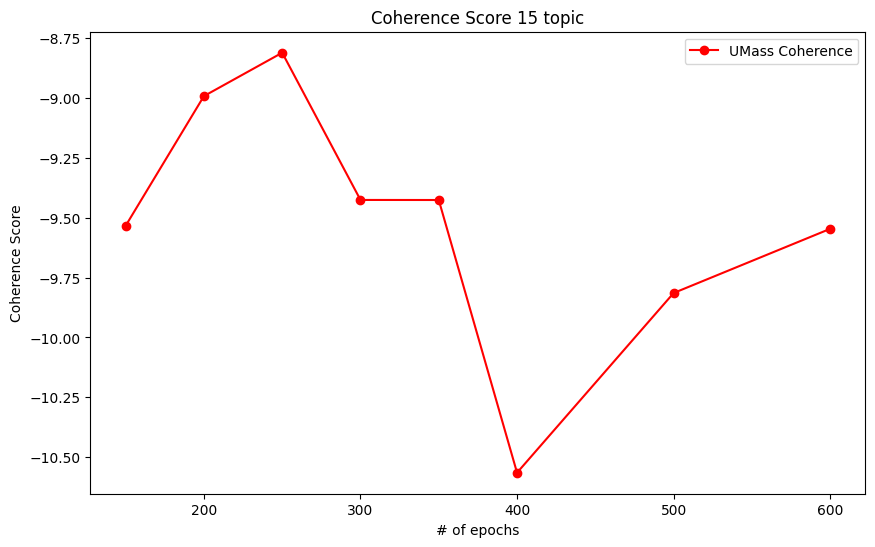

In [41]:
#Mostro i risultati per l'ulteriore addestramento
print(coherence_umass[8:16], epochs)
print("15 topic")
print("Coherence score:", coherence_umass)
plt.figure(figsize=(10,6))
plt.plot(epochs, coherence_umass[8:16], marker='o', color='red', label='UMass Coherence')
plt.legend(loc='best')
plt.title('Coherence Score 15 topic')
plt.xlabel('# of epochs')
plt.ylabel('Coherence Score')
plt.show()

In [43]:
model = LdaModel.load("models/lda_model_15_600")
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True )
pyLDAvis.display(vis)